# Size of credible sets

This notebook was used to calculate the mean size of credible sets


In [ ]:
cs_path = "../../data/credible_set"


In [ ]:
import polars as pl
import seaborn as sns

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("rocket"))


In [26]:
cs = pl.read_parquet(f"{cs_path}/*.parquet")


In [ ]:
def cs_size(locus: pl.Expr) -> pl.Expr:
    """Count the number of unique variants in the credible set locus."""
    return locus.list.len().alias("credibleSetSize")


class DataSourceClass:
    def __init__(self, name: str, condition: pl.Expr):
        self.name = name
        self.condition = condition

    def __repr__(self) -> str:
        """Show string representation of the DataSourceClass."""
        return f"DataSourceClass(name={self.name}, condition={self.condition})"


def classify_by_datasource(datasources: list[DataSourceClass]) -> pl.Expr:
    """Classify the data source based on study type and name."""
    e = pl.when(False).then(None)
    for ds in datasources:
        e = e.when(ds.condition).then(pl.lit(ds.name))
    return e.alias("dataSource")


<Axes: xlabel='dataSource', ylabel='credibleSetSize'>

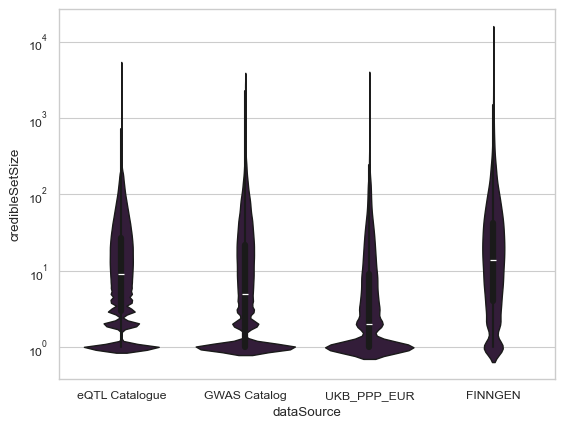

In [48]:
datasources = [
    DataSourceClass("GWAS Catalog", pl.col("studyId").str.starts_with(pl.lit("GCST"))),
    DataSourceClass("FINNGEN", pl.col("studyId").str.contains(pl.lit("FINNGEN"))),
    DataSourceClass("UKB_PPP_EUR", pl.col("studyId").str.starts_with(pl.lit("UKB_PPP_EUR"))),
    DataSourceClass(
        "eQTL Catalogue", ((~pl.col("studyId").str.contains(pl.lit("UKBB"))) & (pl.col("studyType") != pl.lit("gwas")))
    ),
]
data = cs.select(cs_size(pl.col("locus")), classify_by_datasource(datasources)).select("credibleSetSize", "dataSource")

# Add violin plot for all data sources
sns.set_palette(sns.color_palette("rocket"))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.0)
# Create a violin plot
sns.violinplot(data=data, y="credibleSetSize", x="dataSource", log_scale=True)
# Add mean and median lines for each group
